## Import statements

In [85]:
from os import listdir
from re import match
from itertools import product, count

import numpy as np
import matplotlib.pyplot as plt
import skimage

from keras.utils import to_categorical

%matplotlib inline

## Preprocessing captcha texts

List all files in the dataset. It must be in the directory "data"

In [18]:
images = listdir('./data')

In [19]:
images[0]

'6wnyc.png'

We now filter the images (make sure we dont select any other files)

In [24]:
images = list(filter(lambda image: match('^[a-z0-9]+\..+$', image), images))

In [25]:
len(images) == 1070

True

Now we extract the captcha texts from the file names

In [26]:
texts = [match('^([a-z0-9]+)\..+$', image).group(1) for image in images]

Make sure all captchas have a fixed size of 5 tokens

In [27]:
all([len(text) == 5 for text in texts])

True

On captcha texts, we are using lower case letters and digits. <br/>
In total we have an alphabet of 36 chars <br/>
We are going to assign a unique ID to each char

In [29]:
alphabet = [chr(letter) for letter in range(ord('a'), ord('z')+1)] + [chr(ord('0')+digit) for digit in range(0, 10)]

In [31]:
len(alphabet)

36

In [36]:
ids = dict(zip(alphabet, count(0)))

In [37]:
ids['a'], ids['0']

(0, 26)

Now for each captcha text, we replace the characters with their corresponding ids in the alphabet. <br/>
For each text, we will generate a 1x5 vector of integers. <br/>
We stack all this results in a 1070 by 5 matrix

In [58]:
y_labels = np.zeros([len(texts),5], dtype=np.uint8)
for i, j in product(range(0, len(texts)), range(0, 5)):
    text = texts[i]
    y_labels[i, j] = ids[text[j]]

In [60]:
y_labels.shape

(1070, 5)

In [59]:
y_labels[0], texts[0]

(array([32, 22, 13, 24,  2], dtype=uint8), '6wnyc')

We can also encode each label as a sequence of 36 binary values where only 1 element is on and the rest are set to 0 <br/>
If we want to encode for example the digit 0 which has the index 26 in our alphabet, we create a vector of 0s except for the element at position 26 which is set to 1 <br/>
This kind of encoding is useful when working with softmax output layers

In [66]:
y = np.zeros([len(texts), 5, 36], dtype=np.uint8)

In [67]:
for i, j in product(range(0, len(texts)), range(0, 5)):
    y[i, j, :] = to_categorical(y_labels[i, j], 36)

In [71]:
y.shape

(1070, 5, 36)

In [70]:
y[0, 0, :], texts[0][0], ids['6']

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8), '6', 32)

## Captcha images preprocessing

We have a dataset with gray images 50x200. We are going to stack them together in a matrix of size 1070x50x200x1 <br/>
The last number indicates the number of channels. We need only 1 channel

In [72]:
X = np.zeros([len(texts), 50, 200, 1], dtype=np.float32)

In [73]:
for i, image in zip(range(0, len(images)), images):
    x = skimage.io.imread('./data/' + images[0])
    # Make sure all images are 50x200
    assert x.shape[0:2] == (50, 200)
    X[i, :, :, :] = x[:, :, 0].reshape([50, 200, 1])

In [74]:
X[0, :, :, 0]

array([[192., 192., 192., ..., 251., 251., 251.],
       [192., 192., 192., ..., 251., 251., 251.],
       [192., 192., 192., ..., 251., 251., 251.],
       ...,
       [195., 195., 195., ..., 254., 254., 254.],
       [195., 195., 195., ..., 254., 254., 254.],
       [195., 195., 195., ..., 254., 254., 254.]], dtype=float32)

In [75]:
X.shape

(1070, 50, 200, 1)

Now we normalize pixel values in the range [0, 1]

In [76]:
X /= 255

In [77]:
np.max(X), np.min(X)

(1.0, 0.0)

We can visualize a few images

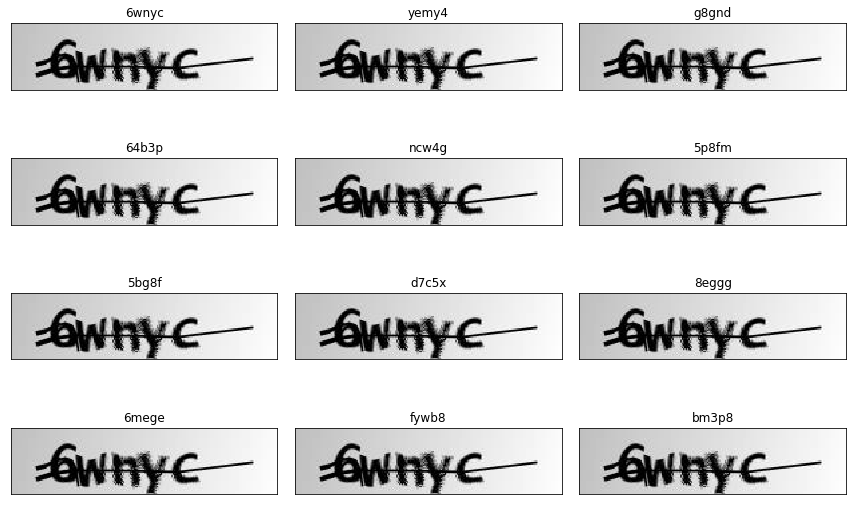

In [82]:
fig, ax = plt.subplots(4, 3, figsize=(12, 8))

for i, j in product(range(0, 4), range(0, 3)):
    plt.sca(ax[i, j])
    k = i * 3 + j
    plt.imshow(X[k, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(texts[k])
plt.tight_layout()

Save the results in a npy file. Use np.load(...) to restore the variables

In [84]:
np.savez_compressed('./preprocessed-data.npz',
                    X=X, y=y, y_labels=y_labels, texts=texts, alphabet=alphabet, ids=ids)